## Introduction

This notebook is adapted from [Laurent Veyssier's notebook](https://github.com/LaurentVeyssier/Semantic-Segmentation-with-Fully-Convolution-Network). It implements the Semantic Segmentation algorithm introduced in [Fully Convolutional Networks for Semantic Segmentation](https://arxiv.org/abs/1411.4038). The following changes are made to the original notebook:

- Use Dataset and DataLoader instead of writing them from scratch
- Add data augmentation
- Add IoU as a metric
- Add evaluation dataset and dataloader

In [272]:
import os
import helper
import math
import random
import re
import sys
import warnings

import cv2
import numpy as np
from glob import glob
from tqdm.auto import tqdm
from skimage import io, transform
from matplotlib import pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchvision.transforms import functional as TF

## Dataset

We use [KITTI road segmentation dataset](https://www.cvlibs.net/datasets/kitti/eval_road.php), which can be downloaded from [here](https://www.cvlibs.net/download.php?file=data_road.zip).

In [ ]:
# Download KITTI-Road-Segmentation dataset
! mkdir -p ./data
! wget -O ./data/data_road.zip https://s3.eu-central-1.amazonaws.com/avg-kitti/data_road.zip
! unzip ./data/data_road.zip -d ./data

In [ ]:
# solution from: https://github.com/NielsRogge/transformers/blob/add_semantic_script/examples/pytorch/semantic-segmentation/run_semantic_segmentation.py
class Compose:
  def __init__(self, transforms):
    self.transforms = transforms

  def __call__(self, image, target):
    for t in self.transforms:
      image, target = t(image, target)
    return image, target

class Resize:
  def __init__(self, size):
    self.size = size

  def __call__(self, image, target):
    image = TF.resize(image, self.size)
    target = TF.resize(target, self.size)
    return image, target

class RandomHorizontalFlip:
  def __init__(self, flip_prob=0.5):
    self.flip_prob = flip_prob

  def __call__(self, image, target):
    if random.random() < self.flip_prob:
      image = TF.hflip(image)
      target = TF.hflip(target)
    return image, target

class RandomVerticalFlip:
  def __init__(self, flip_prob=0.5):
    self.flip_prob = flip_prob

  def __call__(self, image, target):
    if random.random() < self.flip_prob:
      image = TF.vflip(image)
      target = TF.vflip(target)
    return image, target

class RandomRotate:
  def __init__(self, degrees):
    self.degrees = degrees

  def __call__(self, image, target):
    angle = float(torch.empty(1).uniform_(float(self.degrees[0]), float(self.degrees[1])).item())
    image = TF.rotate(image, angle)
    target = TF.rotate(target, angle)
    return image, target

class ToPILImage:
  def __call__(self, image, target):
    image = TF.to_pil_image(image)
    target = TF.to_pil_image(target)
    return image, target

class ToTensor:
  def __call__(self, image, target):
    image = TF.to_tensor(image)
    target = torch.as_tensor(np.array(target), dtype=torch.uint8)
    return image, target

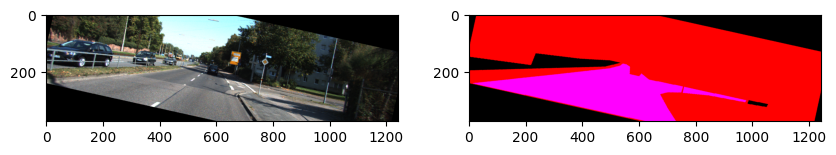

In [269]:
## --------- visualization --------------
%%script false --no-raise-error
image_file = './data/data_road/training/image_2/um_000011.png'
target_file = './data/data_road/training/gt_image_2/um_road_000011.png'
image = io.imread(image_file)
image = transforms.ToPILImage()(image)
target = io.imread(target_file)
target = transforms.ToPILImage()(target)

tfm = RandomRotate([-45, 45])
image, target = tfm(image, target)

figure = plt.figure(figsize=(10, 20))
figure.add_subplot(1,2,1)
plt.imshow(image)
figure.add_subplot(1,2,2)
plt.imshow(target)
plt.show()

In [ ]:
IMG_SZ = 256
image_shape = (256, 256)
train_tfm = Compose([
    ToPILImage(),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    # RandomRotate([-45, 45]),
    # Resize the image into a fixed shape (height = width = IMG_SZ)
    Resize((IMG_SZ, IMG_SZ)),
    # ToTensor() should be the last one of the transforms.
    ToTensor(),
])

test_tfm = transforms.Compose([
    transforms.ToPILImage(),
    # Resize the image into a fixed shape (height = width = IMG_SZ)
    transforms.Resize((IMG_SZ, IMG_SZ)),
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
])

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self, data_folder, mode, transform=None):
    self.image_paths = glob(os.path.join(data_folder, 'image_2', '*.png'))
    self.label_paths = {re.sub(r'_(lane|road)_', '_', os.path.basename(path)): path
                        for path in glob(os.path.join(data_folder, 'gt_image_2', '*_road_*.png'))}
    self.mode = mode
    self.transform = transform
    self.background_color = np.array([255, 0, 0]) # Background is in red.

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    image_file = self.image_paths[idx]
    image = io.imread(image_file)

    if self.mode == 'train':
      gt_image_file = self.label_paths[os.path.basename(image_file)]
      gt_image = io.imread(gt_image_file)                                   # shape H x W x 3

      # Create "one-hot-like" labels by class
      gt_bg = np.all(gt_image == self.background_color, axis=2)             # mask H x W with background from gt_image
      label = ~gt_bg
      label = label.astype('uint8')

    if self.transform:
      if self.mode == 'train':
        image, label = self.transform(image, label)
      else:
        image = self.transform(image)

    # add one dim to 1 x H x W
    # labels format 2, H, W - Bkg in 0, road in 1
    if self.mode == 'train':
      label = label.reshape(1, *label.shape)
      label = torch.concatenate((label, label), axis=0)
      label[1, label[1] == 0] = 2
      label[1, label[1] == 1] = 0
      label[1, label[1] == 2] = 1

    if self.mode == 'train':
      return image, label.float()
    return image


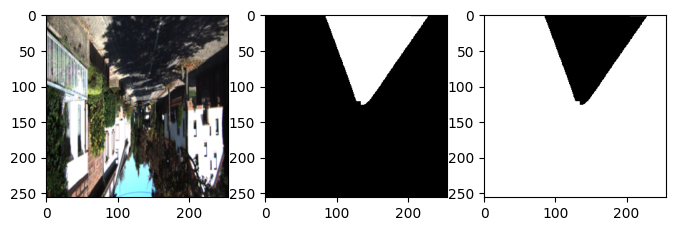

In [ ]:
## --------- visualization --------------
%%script false --no-raise-error
test_dataset = SegmentationDataset('./data/data_road/training', 'train', train_tfm)
figure = plt.figure(figsize=(8,8))
for i, sample in enumerate(test_dataset):
  image, label = sample
  image = torch.permute(image, (1, 2, 0))
  label = torch.permute(label, (1, 2, 0))
  figure.add_subplot(1,3,1)
  plt.imshow(image)
  figure.add_subplot(1,3,2)
  plt.imshow(label[:,:,0], cmap='gray')
  figure.add_subplot(1,3,3)
  plt.imshow(label[:,:,1], cmap='gray')
  break
plt.show()

## DataLoader

In [ ]:
train_ds = SegmentationDataset('./data/data_road/training', 'train', train_tfm)
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)

image scale: 	Min:  tensor(0.0157) 	Max:  tensor(1.)
label scale: 	Min:  tensor(0.) 	Max:  tensor(1.)


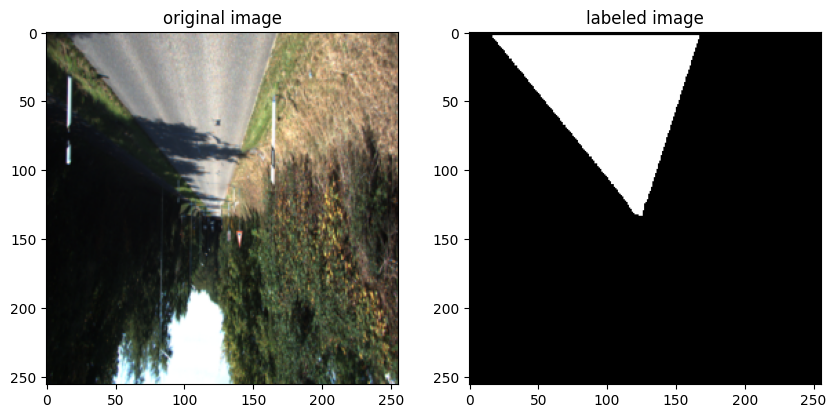

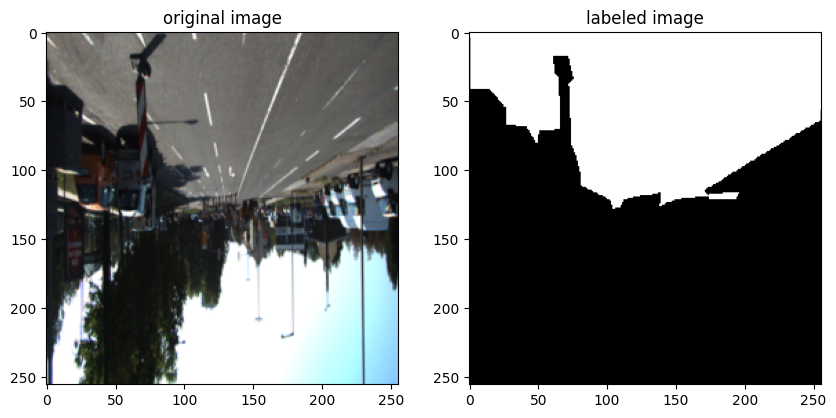

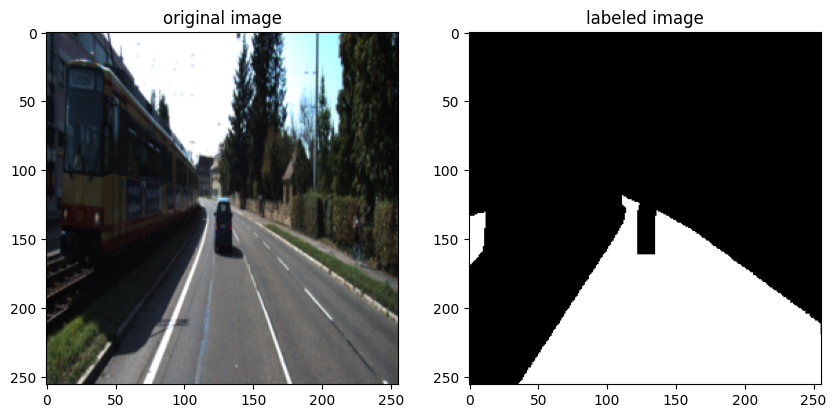

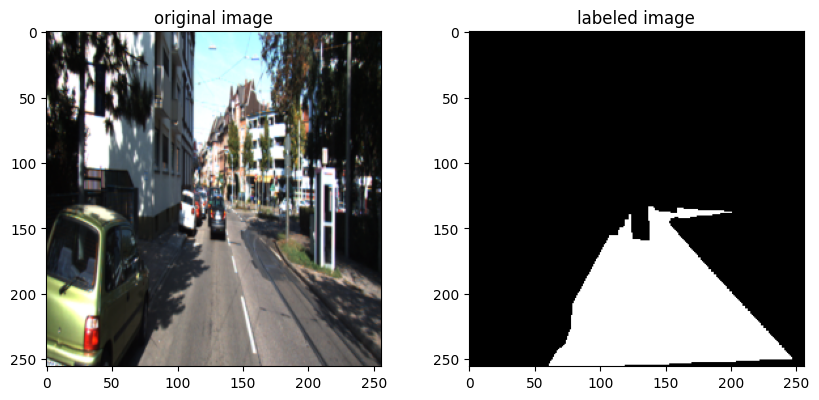

In [270]:
img, label = train_dl.dataset[4]
print('image scale: \tMin: ', img.min(), '\tMax: ', img.max())       # image scale from 0. to 1. expected by pretrained model
print('label scale: \tMin: ', label.min(), '\tMax: ', label.max())   # label scale from 0. to 255.

for batch_i, batch in enumerate(train_dl):
  images, labels = batch
  for i in range(4):
    plt.figure(figsize=(10, 20))

    plt.subplot(i+1, 2, 1)
    img = np.copy(images[i])
    img = np.transpose(img, (1,2,0))
    plt.imshow(img)
    plt.title('original image')

    plt.subplot(i+1, 2, 2)
    lab = np.array(labels[i], dtype=np.uint8)
    lab = np.transpose(lab, (1,2,0))
    plt.imshow(lab[:,:,0], cmap='gray')
    plt.title('labeled image')

    plt.show()
  break

## Going deep with PyTorch

https://blog.paperspace.com/pytorch-101-advanced/

In [ ]:
vgg = models.vgg16(weights=models.VGG16_Weights.DEFAULT).features
print(vgg._modules)
print()
print('layer 0 or input layer: ', vgg._modules['0'])

OrderedDict([('0', Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('1', ReLU(inplace=True)), ('2', Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('3', ReLU(inplace=True)), ('4', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('5', Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('6', ReLU(inplace=True)), ('7', Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('8', ReLU(inplace=True)), ('9', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('10', Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('11', ReLU(inplace=True)), ('12', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('13', ReLU(inplace=True)), ('14', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('15', ReLU(inplace=True)), ('16', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('17', Conv2d(25

In [ ]:
vgg = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
print(vgg._modules['features'])
print()
print('layer 0 or input layer: ', vgg._modules['features'][0])

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [ ]:
print('CHILDREN')
print(list(vgg.children()))
print()
print('MODULES')
print(list(vgg.modules()))
print()
print('NAMED_MODULES')
for x in vgg.named_modules():
  print(x[0], x[1], '\n-----------------------')
print()
print('NAMED_CHILDREN')
for x in vgg.named_children():
  print(x[0], x[1], '\n-----------------------')

CHILDREN
[Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512,

## Model Architecture

In [ ]:
class Encoder(nn.Module):
  def __init__(self, vgg_path):
    super(Encoder, self).__init__()

    self.vgg_path = vgg_path

    if self.vgg_path != None and os.path.exists(os.path.join(self.vgg_path, 'saved_model.pt')):
      model_file = os.path.join(self.vgg_path, 'saved_model.pt')
      vgg.load_state_dict(torch.load(model_file))
    else:
      # Keep the top Conv feature section, and drop the head Linear section.
      self.vgg = models.vgg16(weights=models.VGG16_Weights.DEFAULT).features

      # freeze parameters of pre-trained VGG16 model
      for param in self.vgg.parameters():
        param.requires_grad = False

      self.vgg_path = './data/saved_model'
      model_file = os.path.join(self.vgg_path, 'saved_model.pt')
      if not os.path.exists(model_file):
        try:
          !mkdir -p data/saved_model
          torch.save(self.vgg.state_dict(), model_file)
        except:
          torch.save(self.vgg.state_dict(), model_file)

      if not torch.cuda.is_available():
        summary(self.vgg, (3, 375, 1242))
      else:
        print(self.vgg)

  def forward(self, images):
    vgg_layer3_out_tensor_name = 'layer3_out:0'
    vgg_layer4_out_tensor_name = 'layer4_out:0'
    vgg_layer7_out_tensor_name = 'layer7_out:0'

    layers = {'16': 'MaxPool2d_3_out',
              '23': 'MaxPool2d_4_out',
              '30': 'MaxPool2d_7_out'}

    features = {}

    x = images
    for idx in range(len(self.vgg._modules)):
      layer = self.vgg._modules[str(idx)]
      x = layer(x)
      if str(idx) in layers.keys():
        features[layers[str(idx)]] = x

    return features['MaxPool2d_3_out'], features['MaxPool2d_4_out'], features['MaxPool2d_7_out']


In [ ]:
class Decoder(nn.Module):
  def __init__(self, num_classes=2):
    super(Decoder, self).__init__()

    ## Decoder params
    self.vgg_layer3_depth = 256
    self.vgg_layer4_depth = 512
    self.vgg_layer7_depth = 512
    self.num_classes = num_classes
    self.height = image_shape[0]
    self.width = image_shape[1]

    # Build 1x1 conv sampling and skip connections
    self.skip_vgg_layer4 = nn.Conv2d(in_channels = self.vgg_layer4_depth, out_channels = 256,
                                     kernel_size = (1, 1), stride = 1, padding = 0)
    self.skip_vgg_layer3 = nn.Conv2d(in_channels = self.vgg_layer3_depth, out_channels = 128,
                                     kernel_size = (1, 1), stride = 1, padding = 0)

    # BatchNorm layers
    self.bn1 = nn.BatchNorm2d(256)
    self.bn2 = nn.BatchNorm2d(128)
    self.bn3 = nn.BatchNorm2d(64)
    self.bn4 = nn.BatchNorm2d(32)
    self.bn5 = nn.BatchNorm2d(16)

    # build decoder
    self.deconv1 = nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size = 2,
                                      stride = 2, padding = 0, dilation=1, output_padding=0)
    self.deconv2 = nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = 2,
                                      stride = 2, padding = 0, dilation=1, output_padding=0)
    self.deconv3 = nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 2,
                                      stride = 2, padding = 0, dilation=1, output_padding=0)
    self.deconv4 = nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = 2,
                                      stride = 2, padding = 0, dilation=1, output_padding=0)
    self.deconv5= nn.ConvTranspose2d(in_channels = 32, out_channels = 16, kernel_size = 2,
                                      stride = 2, padding = 0, dilation=1, output_padding=0)
    self.AMP = nn.AdaptiveMaxPool3d(output_size = (2, self.height, self.width))

    # Initialize decoder layers using Xavier's initialization
    self.model_init()

    # To provide lisibility, print tensor dimension when instantiating the model
    self.print_tensor_dims = True

  def forward(self, vgg_layer3_out, vgg_layer4_out, vgg_layer7_out):
    self.batch_size = vgg_layer3_out.shape[0]
    self.vgg_layer3_out = vgg_layer3_out
    self.vgg_layer4_out = vgg_layer4_out
    self.vgg_layer7_out = vgg_layer7_out

    if self.print_tensor_dims: print('VGG F-32 output dims in: \t\t\t\t\t', self.vgg_layer7_out.shape)

    self.vgg_layer4_logits = self.skip_vgg_layer4(self.vgg_layer4_out)

    if self.print_tensor_dims: print('VGG F-16 output dims in: \t\t\t\t\t', self.vgg_layer4_out.shape)

    self.vgg_layer3_logits = self.skip_vgg_layer3(self.vgg_layer3_out)

    if self.print_tensor_dims: print('VGG F-8 output dims in: \t\t\t\t\t', self.vgg_layer3_out.shape)

    # Feed forward decoder

    # Upsampling by 2
    x = F.relu_(self.deconv1(self.vgg_layer7_out))
    if self.print_tensor_dims: print('Dims of Decoder upsampling output deconv1 : \t\t', x.shape)

    # Skip connection
    x = self.bn1(x.add(self.vgg_layer4_logits))
    if self.print_tensor_dims: print('Dims of Decoder upsampling output deconv1 + skip FCN-16 : \t\t', x.shape)

    # Upsampling by 2
    x = F.relu_(self.deconv2(x))
    if self.print_tensor_dims: print('Dims of Decoder upsampling output deconv2 : \t\t', x.shape)

    # Skip connection
    x = self.bn2(x.add(self.vgg_layer3_logits))
    if self.print_tensor_dims: print('Dims of Decoder upsampling output deconv2 + skip FCN-8 : \t\t', x.shape)

    # Upsampling by 8
    x = self.bn3(F.relu_(self.deconv3(x)))
    if self.print_tensor_dims: print('Dims of Decoder upsampling output deconv3 : \t\t', x.shape)

    # Upsampling by 16
    x = self.bn4(F.relu_(self.deconv4(x)))
    if self.print_tensor_dims: print('Dims of Decoder upsampling output deconv4 : \t\t', x.shape)

    # Upsampling by 32
    x = self.bn5(F.relu_(self.deconv5(x)))
    if self.print_tensor_dims: print('Dims of Decoder upsampling output deconv5 : \t\t', x.shape)

    # Bring feature depth to num_classes
    output = self.AMP(x)

    # We ensure appropriate tensor shape: batch_size x num_classes x H x W
    output = output.view(self.batch_size, self.num_classes, self.height, self.width)
    if self.print_tensor_dims: print('Dims of prediction AMP output : \t\t', x.shape)

    self.print_tensor_dims = False
    return output

  def model_init(self):
    torch.nn.init.xavier_uniform_(self.deconv1.weight)
    torch.nn.init.xavier_uniform_(self.deconv2.weight)
    torch.nn.init.xavier_uniform_(self.deconv3.weight)
    torch.nn.init.xavier_uniform_(self.deconv4.weight)
    torch.nn.init.xavier_uniform_(self.deconv5.weight)

In [ ]:
all_train_ds = SegmentationDataset('./data/data_road/training', 'train', train_tfm)
train_size = int(0.8 * len(all_train_ds))
valid_size = len(all_train_ds) - train_size

train_ds, valid_ds = torch.utils.data.random_split(all_train_ds, [train_size, valid_size])
print(f'all train ds size: {len(all_train_ds)}, train ds size: {len(train_ds)}, valid ds size: {len(valid_ds)}')

batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

all train ds size: 289, train ds size: 231, valid ds size: 58


In [ ]:
num_classes = 2
encoder = Encoder(None)
decoder = Decoder(num_classes)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
encoder.to(device)
decoder.to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(decoder.parameters(), lr = 0.001, betas = (0.9, 0.999), eps = 1e-08)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [ ]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('total number of trainable parameters for encoder [%d] and decoder [%d]'
      %(count_parameters(encoder), count_parameters(decoder)))

total number of trainable parameters for encoder [0] and decoder [864080]


In [ ]:
def cmp_iou(pred, target, cls):
  ious = []
  n, _, _ = pred.shape

  pred = pred.view(n, -1)
  pred[pred > 0.5] = 1

  target = target.reshape(n, -1)

  for i in range(n):
    pred_inds = pred[i] == cls
    target_inds = target[i] == cls
    intersection = (pred_inds[target_inds]).long().sum().item()
    union = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection
    if union == 0:
      ious.append(float('nan'))
    else:
      ious.append(intersection / union)

  return ious

In [267]:
! mkdir -p ./data/seg_saved_models

num_epochs = 80
patience = 20
ckpt_name = './data/seg_saved_models/best.ckpt'
best_iou = 0.70119
stale = 0

for epoch in range(num_epochs):
  decoder.train()
  train_losses = []
  train_ious = []

  for batch in tqdm(train_dl):
    images, labels = batch

    images = images.to(device)
    labels = labels.to(device)

    encoder.zero_grad()
    decoder.zero_grad()
    # optimizer.zero_grad()

    # Forward pass.
    vgg_layer3_out, vgg_layer4_out, vgg_layer7_out = encoder(images)
    outputs = decoder(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out)

    # Calculate the batch loss.
    loss = criterion(outputs, labels)

    # Backward pass.
    loss.backward()

    # Update parameters.
    optimizer.step()

    train_losses.append(loss.item())
    ious = cmp_iou(outputs[:, 0], labels[:, 0], 1)
    train_ious.extend(ious)

  train_loss = sum(train_losses) / len(train_losses)
  train_iou = sum(train_ious) / len(train_ious)
  print(f"[ Train | {epoch + 1:03d}/{num_epochs:03d} ] loss = {train_loss:.5f} iou = {train_iou:.5f}")

  decoder.eval()
  valid_losses = []
  valid_ious = []

  for batch in tqdm(valid_dl):
    images, labels = batch
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
      # Forward pass.
      vgg_layer3_out, vgg_layer4_out, vgg_layer7_out = encoder(images)
      outputs = decoder(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out)

      # Calculate the batch loss.
      loss = criterion(outputs, labels)

      valid_losses.append(loss.item())
      ious = cmp_iou(outputs[:, 0], labels[:, 0], 1)
      valid_ious.extend(ious)
  valid_loss = sum(valid_losses) / len(valid_losses)
  valid_iou = sum(valid_ious) / len(valid_ious)
  print(f'[ Valid | {epoch + 1:03d}/{num_epochs:03d} ] loss = {valid_loss:.5f} iou = {valid_iou:.5f}')

  msg = f'[ Valid | {epoch + 1:03d}/{num_epochs:03d} ] loss = {valid_loss:.5f} iou = {valid_iou:.5f}'
  msg += ' -> best' if valid_iou > best_iou else ''
  with open(f'./data/log.txt', 'a') as fid:
    fid.write(msg+'\n')

  if valid_iou > best_iou:
    print(f'Best model found at epoch {epoch+1:03d}, saving model')
    torch.save(decoder.state_dict(), ckpt_name)
    best_iou = valid_iou
    stale = 0
  else:
    stale += 1
    if stale > patience:
      print(f'No improvment {patience} consecutive epochs, early stopping')
      break;

  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 001/080 ] loss = 0.22824 iou = 0.84285


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 001/080 ] loss = 0.27959 iou = 0.70267
Best model found at epoch 001, saving model


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 002/080 ] loss = 0.22629 iou = 0.84401


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 002/080 ] loss = 0.28601 iou = 0.68531


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 003/080 ] loss = 0.22493 iou = 0.85056


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 003/080 ] loss = 0.28105 iou = 0.69555


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 004/080 ] loss = 0.22431 iou = 0.85220


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 004/080 ] loss = 0.29327 iou = 0.68797


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 005/080 ] loss = 0.22247 iou = 0.85200


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 005/080 ] loss = 0.28431 iou = 0.70203


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 006/080 ] loss = 0.22232 iou = 0.85342


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 006/080 ] loss = 0.28133 iou = 0.67985


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 007/080 ] loss = 0.22060 iou = 0.85167


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 007/080 ] loss = 0.27652 iou = 0.69383


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 008/080 ] loss = 0.21856 iou = 0.85744


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 008/080 ] loss = 0.28005 iou = 0.68322


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 009/080 ] loss = 0.22208 iou = 0.84962


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 009/080 ] loss = 0.27646 iou = 0.69283


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 010/080 ] loss = 0.21846 iou = 0.85841


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 010/080 ] loss = 0.27994 iou = 0.69493


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 011/080 ] loss = 0.21760 iou = 0.85962


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 011/080 ] loss = 0.28486 iou = 0.68832


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 012/080 ] loss = 0.21578 iou = 0.86211


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 012/080 ] loss = 0.27666 iou = 0.69921


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 013/080 ] loss = 0.21584 iou = 0.86040


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 013/080 ] loss = 0.29238 iou = 0.67321


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 014/080 ] loss = 0.21390 iou = 0.85953


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 014/080 ] loss = 0.26956 iou = 0.70919
Best model found at epoch 014, saving model


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 015/080 ] loss = 0.21021 iou = 0.86928


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 015/080 ] loss = 0.27699 iou = 0.69855


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 016/080 ] loss = 0.21060 iou = 0.86607


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 016/080 ] loss = 0.27352 iou = 0.69840


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 017/080 ] loss = 0.21102 iou = 0.86865


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 017/080 ] loss = 0.27551 iou = 0.69745


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 018/080 ] loss = 0.20924 iou = 0.87255


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 018/080 ] loss = 0.27617 iou = 0.69033


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 019/080 ] loss = 0.21194 iou = 0.86617


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 019/080 ] loss = 0.27491 iou = 0.68829


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 020/080 ] loss = 0.21029 iou = 0.86449


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 020/080 ] loss = 0.27872 iou = 0.69892


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 021/080 ] loss = 0.20856 iou = 0.86276


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 021/080 ] loss = 0.27422 iou = 0.70384


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 022/080 ] loss = 0.20531 iou = 0.86784


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 022/080 ] loss = 0.27777 iou = 0.69321


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 023/080 ] loss = 0.20331 iou = 0.87382


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 023/080 ] loss = 0.27231 iou = 0.70716


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 024/080 ] loss = 0.20264 iou = 0.87267


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 024/080 ] loss = 0.27967 iou = 0.69015


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 025/080 ] loss = 0.19974 iou = 0.88014


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 025/080 ] loss = 0.27385 iou = 0.68035


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 026/080 ] loss = 0.20250 iou = 0.87691


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 026/080 ] loss = 0.27328 iou = 0.69009


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 027/080 ] loss = 0.19884 iou = 0.88075


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 027/080 ] loss = 0.28116 iou = 0.69488


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 028/080 ] loss = 0.20045 iou = 0.87537


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 028/080 ] loss = 0.27537 iou = 0.69282


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 029/080 ] loss = 0.19978 iou = 0.87484


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 029/080 ] loss = 0.26813 iou = 0.70835


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 030/080 ] loss = 0.19761 iou = 0.87895


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 030/080 ] loss = 0.26884 iou = 0.68436


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 031/080 ] loss = 0.19803 iou = 0.87875


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 031/080 ] loss = 0.26588 iou = 0.69830


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 032/080 ] loss = 0.19705 iou = 0.87854


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 032/080 ] loss = 0.27125 iou = 0.69746


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 033/080 ] loss = 0.19559 iou = 0.88057


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 033/080 ] loss = 0.27123 iou = 0.70119


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 034/080 ] loss = 0.19380 iou = 0.88319


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 034/080 ] loss = 0.27166 iou = 0.69587


  0%|          | 0/8 [00:00<?, ?it/s]

[ Train | 035/080 ] loss = 0.19294 iou = 0.88229


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 035/080 ] loss = 0.26843 iou = 0.70083
No improvment 20 consecutive epochs, early stopping


## Inference

VGG F-32 output dims in: 					 torch.Size([6, 512, 8, 8])
VGG F-16 output dims in: 					 torch.Size([6, 512, 16, 16])
VGG F-8 output dims in: 					 torch.Size([6, 256, 32, 32])
Dims of Decoder upsampling output deconv1 : 		 torch.Size([6, 256, 16, 16])
Dims of Decoder upsampling output deconv1 + skip FCN-16 : 		 torch.Size([6, 256, 16, 16])
Dims of Decoder upsampling output deconv2 : 		 torch.Size([6, 128, 32, 32])
Dims of Decoder upsampling output deconv2 + skip FCN-8 : 		 torch.Size([6, 128, 32, 32])
Dims of Decoder upsampling output deconv3 : 		 torch.Size([6, 64, 64, 64])
Dims of Decoder upsampling output deconv4 : 		 torch.Size([6, 32, 128, 128])
Dims of Decoder upsampling output deconv5 : 		 torch.Size([6, 16, 256, 256])
Dims of prediction AMP output : 		 torch.Size([6, 16, 256, 256])


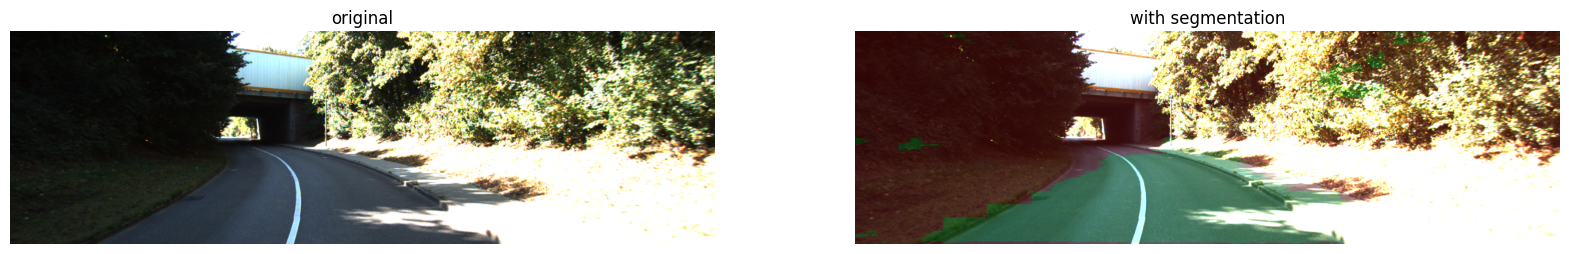

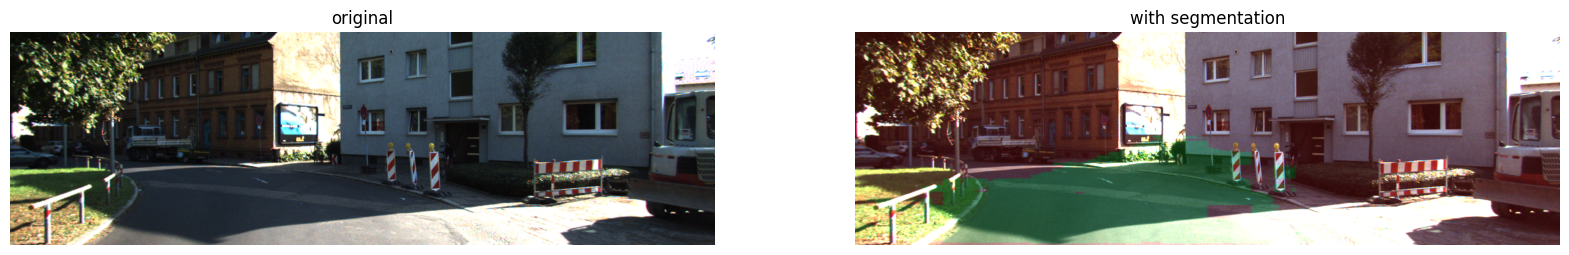

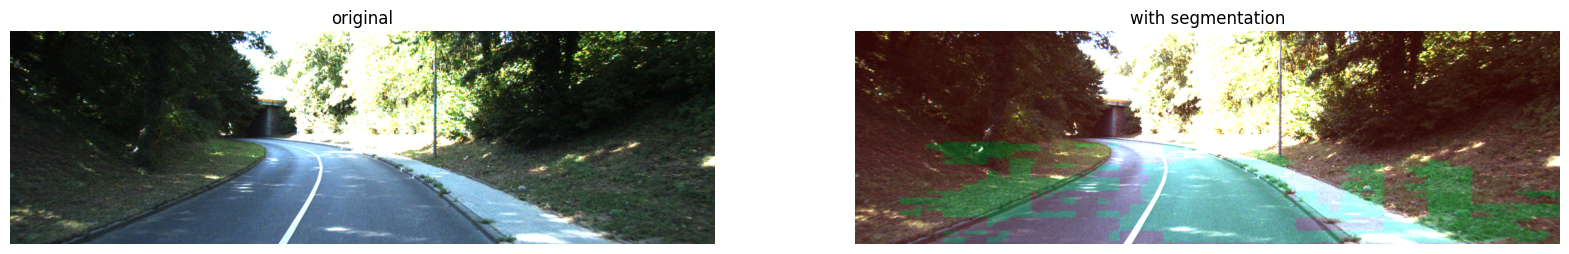

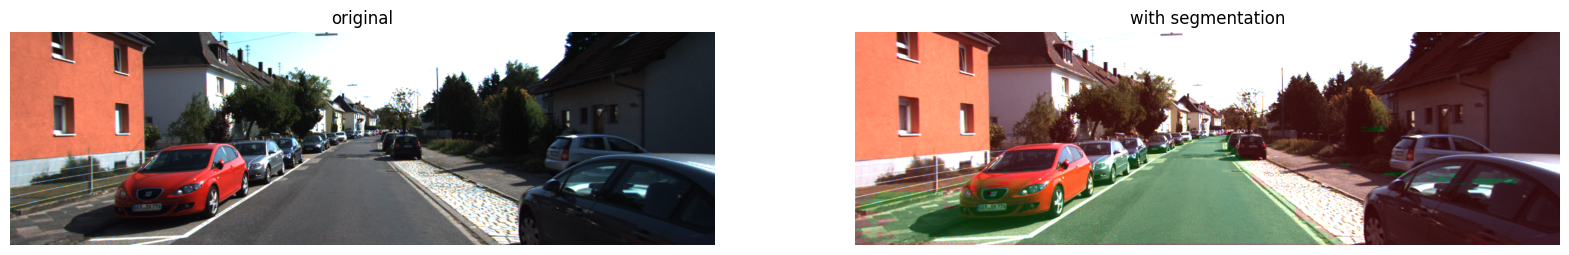

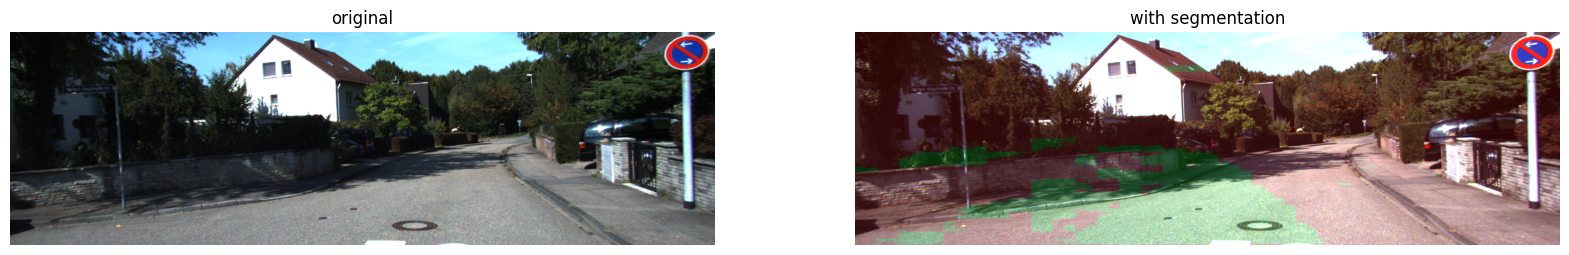

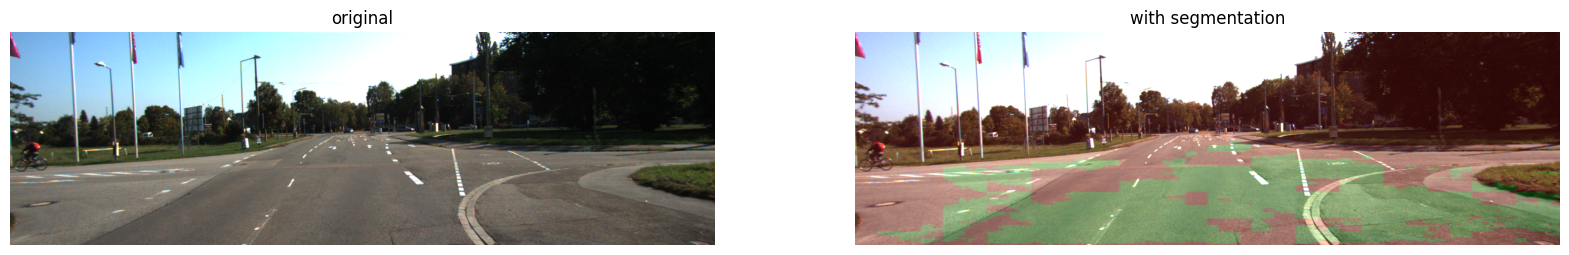

In [271]:
image_paths = glob(os.path.join('./data/data_road/testing/image_2', '*.png'))

# Visualize sample data
best_decoder = Decoder(num_classes)
best_decoder.load_state_dict(torch.load(ckpt_name))
best_decoder = best_decoder.to(device)
best_decoder.eval()

# Obtain one batch of testing images
test_ds = SegmentationDataset('./data/data_road/testing', 'test', test_tfm)
test_dl = DataLoader(test_ds, batch_size=6, shuffle=True)

with torch.no_grad():
  for images in test_dl:
    images = images.to(device)

    # Pass the inputs through the FCN model.
    vgg_layer3_out, vgg_layer4_out, vgg_layer7_out = encoder(images)
    outputs = best_decoder(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out) # batch_size x num_classes x H x W
    outputs = torch.sigmoid(outputs)

    for index, output in enumerate(outputs):
      # Get the predictions
      pred = output.detach().cpu().numpy()                         # 2 x H x W
      pred = pred.transpose((1, 2, 0))                             # H x W x 2
      pred = pred.argmax(axis=2)
      pred = (pred > 0.5)                                          # retain pixels coming from channel 1 not channel 0 (ind=0)

      # Prepare 3D mask with road detected in light red (channel1), non-road in light green (channel2)
      pred = pred.reshape(*pred.shape, 1)                                      # H x W x 1  True = road, False otherwise
      pred = np.concatenate((pred, np.invert(pred)), axis=2).astype('float')   # H x W x 2  inverse on channel 2
      pred = np.concatenate((pred, np.zeros((*pred[:,:,0].shape, 1))), axis=2).astype('float')  # H x W x 3 channel3 with zeros

      # Channel1 road = 127, 0 elsewhere; channel2 Non-road=127, 0 elsewhere, Channel3 only 0s
      pred[pred == 1.0] = 127.0

      # Combine mask with image
      img = io.imread(image_paths[index])
      pred = cv2.resize(pred, (img.shape[1],img.shape[0]))
      img = np.array(img, dtype='uint8')

      # Merge original image with mask
      street = cv2.addWeighted(img, 0.6, pred, 0.15, 0, dtype = 0)
      street = street/127.0
      street = np.clip(street, 0.0, 1.0)                               # required imshow format: ndarray of integers

      # Display
      plt.figure(figsize=(20,40))
      plt.subplot(1,2,1)
      plt.imshow(img)
      plt.title('original')
      plt.axis('off')
      plt.subplot(1,2,2)
      plt.imshow(street)
      plt.title('with segmentation')
      plt.axis('off')
      plt.show()
    break